In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
import statsmodels.api as sm

In [29]:
members = pd.read_csv(r'E:\KKbox\members_v3.csv')
members =members.loc[(members['bd']>2) & (members['bd']<99)]
train = pd.read_csv(r'E:\KKbox\train.csv')
df = pd.merge(members,train,how='inner',on=['msno'])
df = df.iloc[0:100000]
msnos = df['msno']
relevant_user_logs = pd.read_csv(r'E:\KKbox\feb_user_logs.csv')
#relevant_transactions = pd.read_csv(r'C:\Users\liamc\OneDrive\Desktop\Data Science\KKbox\relevant_transactions.csv')                                 

In [30]:
df['registration_init_time'] = pd.to_datetime(df['registration_init_time'],format='%Y%m%d')

In [31]:
mean_user_logs = pd.DataFrame(index=[],columns=[])

In [32]:
mean_user_logs['num_25'] = relevant_user_logs.groupby('msno')['num_25'].mean()
mean_user_logs['num_50'] = relevant_user_logs.groupby('msno')['num_50'].mean()
mean_user_logs['num_75'] = relevant_user_logs.groupby('msno')['num_75'].mean()
mean_user_logs['num_985'] = relevant_user_logs.groupby('msno')['num_50'].mean()
mean_user_logs['num_100'] = relevant_user_logs.groupby('msno')['num_100'].mean()
mean_user_logs['num_unq'] = relevant_user_logs.groupby('msno')['num_unq'].mean()
mean_user_logs['total_secs'] = relevant_user_logs.groupby('msno')['total_secs'].mean()
mean_user_logs['days_logged'] = relevant_user_logs.groupby('msno')['date'].count()

In [33]:
mean_user_logs = mean_user_logs.reset_index()

In [34]:
df = pd.merge(df,mean_user_logs,how='inner',on='msno')

In [35]:
end_day = datetime.date(2017,3,1)
df['days_since_registered'] = end_day - df['registration_init_time']
df['days_since_registered'] = df['days_since_registered'].dt.days

In [36]:
df = pd.get_dummies(df,columns=['city','registered_via','gender'])

In [37]:
df = df.drop(['registration_init_time'],axis=1)

In [38]:
df.is_churn.sum()

2216

In [12]:
df.shape

(38150, 40)

In [ ]:
churners= df.loc[df['is_churn']==1]
nonchurners= df.loc[df['is_churn']==0]
nonchurners= nonchurners.sample(n=10000,random_state=17)
df = pd.concat([churners,nonchurners])

In [13]:
y = df['is_churn']
#X = df.drop(['is_churn','msno'],axis=1)
X = df[['num_25','num_75','num_100','num_unq','days_logged','days_since_registered','gender_female','gender_male']]

In [14]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [15]:
vif

,VIF Factor,features
0,2.304597,num_25
1,2.033818,num_75
2,5.363678,num_100
3,8.273911,num_unq
4,7.456713,days_logged
5,3.906766,days_since_registered
6,5.541758,gender_female
7,5.924684,gender_male


In [16]:
y = df['is_churn']
X = df.drop(['is_churn','msno'],axis=1)
#X = df[['num_25','num_75','num_100','num_unq','days_logged','days_since_registered','gender_female','gender_male']]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3,random_state=21)


In [18]:
len(X_test)

11445

In [19]:
rfclf = RandomForestClassifier()

In [20]:
rfclf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [21]:
y_pred = rfclf.predict(X_test)

In [22]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[10762    11]
 [  671     1]]
             precision    recall  f1-score   support

          0       0.94      1.00      0.97     10773
          1       0.08      0.00      0.00       672

avg / total       0.89      0.94      0.91     11445



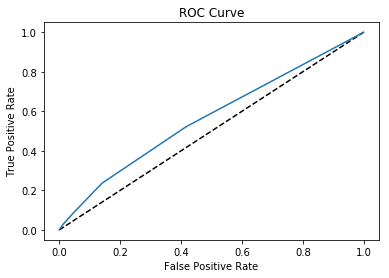

In [23]:
y_pred_prob = rfclf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [24]:
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))
cv_auc = cross_val_score(rfclf,X,y,cv=5,scoring='roc_auc')
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

AUC: 0.5659710481008517
AUC scores computed using 5-fold cross-validation: [0.56145292 0.56656253 0.5785168  0.56585929 0.57417137]


In [25]:
y_pred_prob.max()

0.9

In [26]:
c_space = np.logspace(-5, 8, 15)
param_grid = {'C':c_space, 'penalty': ['l1', 'l2']}
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)
logreg_cv.fit(X,y)
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

NameError: name 'logreg' is not defined

In [27]:
log_loss(y_test,y_pred_prob)

1.0924681848651094